# <center>Entrenar y evaluar una red neuronal convolucional para resolver un problema de clasificación de imágenes</center>

<div style="background-color: #fdebd0 ">
<b>Este TP tiene 3 objetivos:</b><br>
- Describir conceptos vinculados al entrenamiento y uso de <i>ConvNets</i> para la clasificación de imágenes<br>
- Familiarizarse con la librería PyTorch<br>
- Reproducir un protocolo para entrenar una red neuronal convolucional y clasificar imágenes.</div>


PyTorch es una librería de aprendizaje automático de código abierto para Python, desarrollada principalmente por el grupo de investigación de inteligencia artificial de Facebook. Dentro de PyTorch, el paquete <code>torchvision</code> consiste en conjuntos de datos populares, arquitecturas de modelos y transformaciones de imágenes comunes para la visión artificial.

En la primera parte del trabajo práctico, utilizaremos el conjunto de datos CIFAR10 disponible en <code>torchvision</code>.  Este dataset sirve para aprender a resolver un problema de clasificación con 10 clases: 'avión', 'automóvil', 'pájaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión'. Las imágenes en CIFAR-10 son de tamaño 3x32x32, es decir, imágenes en color de 3 canales de 32x32 píxeles de tamaño: https://www.cs.toronto.edu/~kriz/cifar.html

El código está basado en el tutorial de PyTorch siguiente: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

<img src="cifar10.png"></img>

Para resolver el problema de clasificación de imágenes, seguiremos los siguientes pasos:

- Cargar y normalizar los conjuntos de datos de entrenamiento y pruebas utilizando CIFAR10.
- Configurar una red neuronal de convolución
- Definir una función de pérdida
- Optimizar la red sobre los datos de entrenamiento
- Probar el rendimiento de la red con los datos de test

Por cada paso, se solicita responder a una serie de preguntas.

## 1. Cargar y normalizar el dataset CIFAR10

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

#The output of torchvision datasets are PILImage images of range [0, 1]. 
#We transform them to Tensors of normalized range [-1, 1].

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


<div style="background-color: #fdebd0 ">
<b>Preguntas</b><br>
1) ¿Cuál es el tamaño del dataset de entrenamiento y del dataset de test? (Imprimir el resultado con la función <code>print</code>)<br>
2) ¿Por qué el parametro <code>shuffle</code> se configura "True" para el dataset de entrenamiento y "False" para el dataset de test? ¿De qué sirve este parametro?<br>


<div style="background-color:#45b39d ">Sus respuestas...</div>

In [2]:
print("train:",len(trainset),"\ntest:",len(testset))

train: 50000 
test: 10000


<b>R:</b>shuffle se define verdadero para revolver la data en cada época,lo que significa que en cada iteración se toman datos distintos, ya que para el dataset de prueba es necesario tener datos fijos se define como FALSE

El código siguiente permite mostrar imagenes aleatorias del dataset de entrenamiento y su etiqueta real:

In [3]:

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def imagesFromBatches(iterator,quantity):
    dataiter = iter(iterator)
    images, labels = dataiter.next()    
    imshow(torchvision.utils.make_grid(images))
    print(' '.join('%5s' % classes[labels[j]] for j in range(quantity)))
    return (images,labels)

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

<Figure size 640x480 with 1 Axes>

plane  deer   car   cat


## 2. Configurar la CNN

In [4]:
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net1 = Net()

summary(net1,(3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


<div style="background-color: #fdebd0 ">
<b>Preguntas</b><br>
1) ¿Cuántas capas tiene esta ConvNet?<br><b>7 capas, 2 convoluciones, 2 pooling, (1 view) y 3 fully connected</b><br>
2) Explicar los parametros de cada capa. ¿Cuántos filtros se utilizan en las capas de convolución? ¿Cuál es el tamaño de los filtros? <br><b>6 filtros de 5x5 en la primera convolucion y 16 de 5x5 en la segunda convolucion </b><br>
3) ¿Cuál es la diferencia entre la función <code>init</code> y <code>forward</code>?<br><b>init define las instrucciones mientras que forward las ejecuta y enlaza, define cual instuccion sigue a cual</b><br>
4) ¿De qué sirve la función view()? Explicar sus parametros.<br><b>"aplana" la imagen convirtiendo las multiples capas a vectores</b><br>
5) ¿Cuántos paramétros en total se tiene que aprender con esta ConvNet? <br><b>62006 parametros</b><br>
6) ¿Por qué se utiliza la función <code>conv2d</code> aunque tenemos imagenes con 3 canales?<b>por que estamos trabajando con obetos 2d(información bimensional), los 3 canales son para interpretar la información 2d</b>
</div>

## 3. Entrenar la CNN

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)

In [21]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.157
[1,  4000] loss: 1.838
[1,  6000] loss: 1.685
[1,  8000] loss: 1.572
[1, 10000] loss: 1.524
[1, 12000] loss: 1.453
[2,  2000] loss: 1.400
[2,  4000] loss: 1.374
[2,  6000] loss: 1.350
[2,  8000] loss: 1.309
[2, 10000] loss: 1.286
[2, 12000] loss: 1.293
[3,  2000] loss: 1.203
[3,  4000] loss: 1.186
[3,  6000] loss: 1.194
[3,  8000] loss: 1.224
[3, 10000] loss: 1.180
[3, 12000] loss: 1.181
[4,  2000] loss: 1.094
[4,  4000] loss: 1.098
[4,  6000] loss: 1.097
[4,  8000] loss: 1.103
[4, 10000] loss: 1.085
[4, 12000] loss: 1.095
Finished Training


- Ver la video: https://www.youtube.com/watch?v=ErfnhcEV1O8 - A Short Introduction to Entropy, Cross-Entropy and KL-Divergence

- Leer: http://ruder.io/optimizing-gradient-descent/index.html - An overview of gradient descent optimization algorithm

<div style="background-color: #fdebd0 ">
<b>Preguntas</b><br>
1) ¿Qué hace la función <code>CrossEntropyLoss</code>? Qué devuelve? Con qué otra función se podría reemplazar <code>CrossEntropy</code>?<br><b>genera un criterion que calcula la Perdida de Entropia Cruzada. retorna un valor entre 0 y 'C'-1, indicando que tan errada esta la predicción (menor es mejor).
    Se podria reemplazar por una combinacion de nn.LogSoftmax y nn.NLLLoss</b><br>
2) ¿Cuál es la diferencia principal entre los métodos de optimización Gradient Descent, Stochastic Gradient Descent y Mini-Batch Gradient Descent?<br><b>Gradient Descent is an iterative method to solve the optimization problem. There is no concept of "epoch" or "batch" in classical gradient decent. The key of gradient decent are
    -Update the weights by the gradient direction.<br>
    -The gradient is calculated precisely from all the data points.<br>
Stochastic Gradient Descent can be explained as: quick and dirty way to "approximate gradient" from one single data point. If we relax on this "one single data point" to "a subset of data", then the concepts of batch and epoch come.<br>mini-batch gradient has a little bit noisy cost function but still trend downwards. The reason for the noise is that there are some harder mini batches which cause oscillation to cost function.
</b><br>
3) ¿En nuestro ejemplo, qué método utilizamos? En qué parte del código se podría cambiar el tamaño del batch?<br><b>usamos SGD, en la definicion de los sets(al comienzo del notebook)</b><br>
4) ¿Qué metafora podemos utilizar para entender la idea del parametro <code>momentum</code>?<br><b>la "fuerza" con la que se mueve un objeto en una direccion, el salto que da el SGD</b><br>Link interesante: <a>https://stats.stackexchange.com/questions/179915/whats-the-difference-between-momentum-based-gradient-descent-and-nesterovs-acc</a><br>
5) ¿Podría ser útil aumentar el número de epoch? ¿Por qué? De qué sirve este parametro?<br><b>Es útil aumentar el número de epoch si la función de pérdida es muy elevada, por contraparte, si se aumentan las epoch en exceso, es muy probable que se llegue a un valor no aconsejable, que se aleje del óptimo en vez de acercarse.El número de Epoch sirve para iterar sobre las iteraciones de SGD en este caso</b><br>

</div>

## 4. Evaluar la CNN

Tomamos 4 ejemplos del dataset de test:

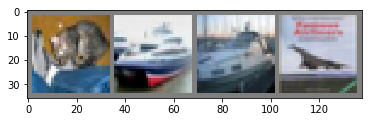

  cat  ship  ship plane


In [22]:
BatchSize=4

images,labels= imagesFromBatches(testloader,BatchSize)

Clasificamos estas 4 imágenes con nuestra CNN: 

In [24]:
outputs = net1(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(BatchSize)))

Predicted:    cat  ship  ship plane


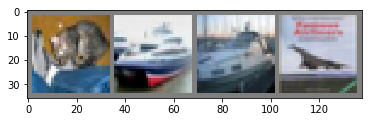

  cat  ship  ship plane
Accuracy of the network on the 4 test images: 100 %


In [25]:
correct = 0
total = 0
with torch.no_grad():
        images, labels = imagesFromBatches(testloader,BatchSize)
        outputs = net1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (BatchSize,
    100 * correct / total))

<div style="background-color: #fdebd0 ">
<b>Pregunta</b><br>
1) ¿Cuál es el rendimiento del modelo entrenado sobre estos primeros ejemplos?<br><b>Revisar celda anterior</b><br>

</div>

Calculamos el rendimiento de nuestra CNN sobre todos los datos del training set:

In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 60 %


Miramos el rendimiento de la CNN calculando su exactitud según cada etiqueta:

In [28]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net1(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 55 %
Accuracy of   car : 80 %
Accuracy of  bird : 52 %
Accuracy of   cat : 32 %
Accuracy of  deer : 43 %
Accuracy of   dog : 54 %
Accuracy of  frog : 73 %
Accuracy of horse : 69 %
Accuracy of  ship : 75 %
Accuracy of truck : 68 %


<div style="background-color: #fdebd0 ">
<b>Preguntas:</b><br>
1) ¿Qué paramétros podrían modificar para tratar de mejorar el rendimiento de la CNN? <br><b>Se pueden modificar tanto el BatchSize como el numero de Epoch, Learning Rate, Capas de convolucion, de pool, modificar los filtros, Tambien es posible cambiar la Arquitectura</b><br>
2) ¿Cómo se llama la arquitectura de CNN que hemos utilizado? (ver slides del curso y https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5 y https://adeshpande3.github.io/The-9-Deep-Learning-Papers-You-Need-To-Know-About.html)<br><b>LeNet-5</b><br>
3) ¿Qué pasa si tratan de agregar más filtros en la segunda capa de convolución? <br><b>aumentan/disminuyen los parametros si es que se incrementan/decrementan los filtros</b><br>
4) ¿Qué pasa si trata de agregar una tercera capa de convolución y pooling? <br><b>LeNet-5 esta definido de la forma ya planteada, si se agregase otra capa de convolucion y pooling, el código no funcionaría, como se ve en la celda de abajo</b><br>
5) ¿En la literatura, qué arquitecturas CNN permiten obtener mejores rendimiento que la arquitectura LeNet-5? Cuál es el limite de estas arquitecturas? <br><b>
<ul>
    <li>AlexNet, basado en LeNet, consiste en 60 millones de parametros, usa 2 GPU, entrenamiento por 6 dias</li>
    <li>ZFNet, basado en AlexNet</li>
    <li>GoogleNet(a.k.a. Inception V1), basado en LeNet, consiste en 4 millones de parametros</li>
    <li>VGGNet, similar a AlexNet, consiste en 138 millones de parametros, entrenamiento con 4 GPU por 2~3 semanas</li>
    <li>ResNet <italic>(introduccion tecnologia SKIP CONNECTIONS)</italic>,</li>
    <li>Region Based CNNs(R-CNN, Fast R-CNN, Faster R-CNN)</li>
</ul>  
    Mayormente las restricciones de estas arquitecturas va en el Hardware, el tiempo de entrenamiento, y la cantidad de parametros a utilizar
</b>
<br>
</div>

In [31]:
summary(net1,(3,32,32))

import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 24, 5)
        self.fc1 = nn.Linear(24 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 24 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net2 = Net()

summary(net2,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


RuntimeError: shape '[-1, 256]' is invalid for input of size 32

<div style="background-color: #fdebd0 ">
<b>T.P</b><br>
Optimizar una CNN para resolver el problema asociado al dataset Fashion-MNIST (https://pytorch.org/docs/stable/torchvision/datasets.html#fashion-mnist). <br>

1) ¿La arquitectura LeNet-5 es mejor que Random Forest? Comparar el rendimiento obtenido con lo obtenido por el algoritmo RandomForest (con 50 estimadores).
</div>

# Descompresión datos, proceso necesario ambos métodos!!!!

In [2]:
import zipfile
zip_ref = zipfile.ZipFile("FashionMNIST/processed/fashion-mnist_test.csv.zip", 'r')
zip_ref.extractall("FashionMNIST/processed/")
zip_ref.close()
zip_ref = zipfile.ZipFile("FashionMNIST/processed/fashion-mnist_train.csv.zip", 'r')
zip_ref.extractall("FashionMNIST/processed/")
zip_ref.close()

# ConvNet LeNET-5
#### Código original: https://www.kaggle.com/tinydman/fashion-mnist-with-pytorch

In [43]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
trainSet=pd.read_csv("FashionMNIST/processed/fashion-mnist_train.csv")
testSet=pd.read_csv("FashionMNIST/processed/fashion-mnist_test.csv")

BATCH_SIZE = 50
LR = 0.005
NUM_CLASS = 10
IMAGE_SIZE = 28
CHANNEL = 1
Train_epoch = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CLASS_CLOTHING = {0 :'T-shirt/top',
                  1 :'Trouser',
                  2 :'Pullover',
                  3 :'Dress',
                  4 :'Coat',
                  5 :'Sandal',
                  6 :'Shirt',
                  7 :'Sneaker',
                  8 :'Bag',
                  9 :'Ankle boot'}



In [39]:
class MyDataset(Dataset):
    '''
    Build your own dataset
    '''
    def __init__(self, data, transform = None):
        self.fashion_mnist = list(data.values)
        self.transform = transform
        label, img = [],[]
        for one_line in self.fashion_mnist:
            label.append(one_line[0])
            img.append(one_line[1:])
        self.label = np.asarray(label)
        self.img = np.asarray(img).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, CHANNEL).astype('float32')

    def __getitem__(self, item):
        label, img = self.label[item], self.img[item]
        if self.transform is not None:
            img = self.transform(img)

        return label, img

    def __len__(self):
        return len(self.label)

In [40]:
My_transform = transforms.Compose([
    transforms.ToTensor(),# default : range [0, 255] -> [0.0,1.0]
])
Train_data = MyDataset(trainSet, transform=My_transform)
Test_data = MyDataset(testSet, transform=My_transform)

Train_dataloader = DataLoader(dataset=Train_data,
                              batch_size = BATCH_SIZE,
                              shuffle=False
                              )
Test_dataloader = DataLoader(dataset=Test_data,
                              batch_size = BATCH_SIZE,
                              shuffle=False
                              )

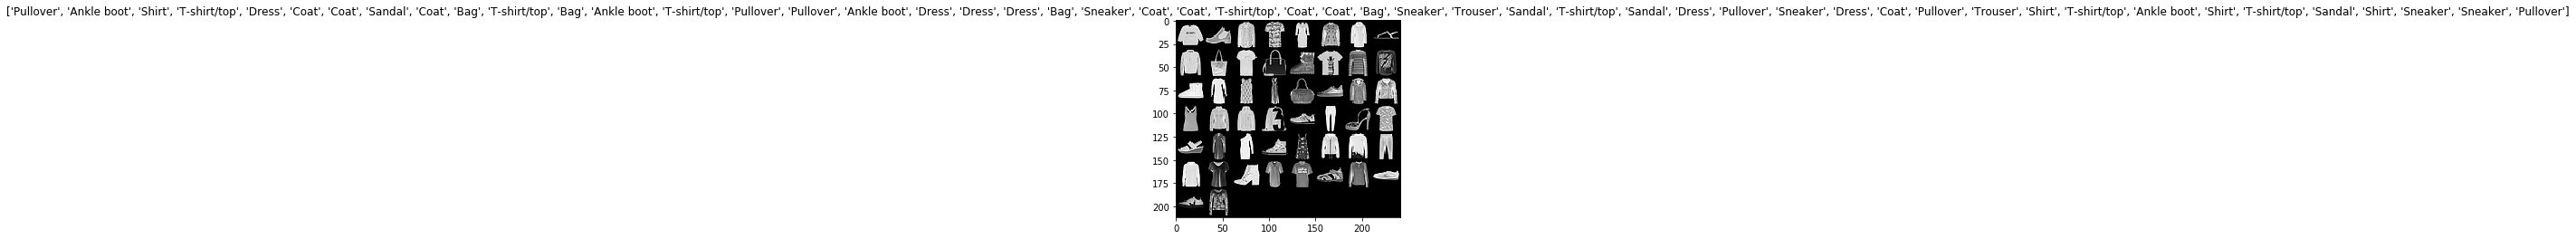

In [44]:
data_iter = iter(Train_dataloader)# at this time I set batch_size = 4
label , img = next(data_iter)

def imshow(img, title):
    img = torchvision.utils.make_grid(img)/255
    img = img.numpy().transpose([1, 2, 0])
    plt.imshow(img)
    if title is not None:
        plt.title(title)

imshow(img, [CLASS_CLOTHING[x] for x in label.numpy().tolist()])
plt.show()

In [45]:
class My_Model(nn.Module):
    def __init__(self, num_of_class):
        super(My_Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 32, num_of_class)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [46]:
def train():
    model = My_Model(NUM_CLASS).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = LR)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, Train_epoch + 1):
        for batch_id, (label, image) in enumerate(Train_dataloader):
            label, image = label.to(device), image.to(device)
            output = model(image)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_id % 1000 == 0:
                print('Loss :{:.4f} Epoch[{}/{}]'.format(loss.item(), epoch, Train_epoch))
    return model

In [47]:
def test(model):
    with torch.no_grad():
        correct = 0
        total = 0
        for label , image in Test_dataloader:
            image = image.to(device)
            label = label.to(device)
            outputs = model(image)
            predicted = torch.argmax(outputs,dim=1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
        print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

In [48]:
if __name__ == '__main__':
    model = train()
    test(model)

Loss :2.3311 Epoch[1/5]
Loss :0.4285 Epoch[1/5]
Loss :0.4626 Epoch[2/5]
Loss :0.3301 Epoch[2/5]
Loss :0.3754 Epoch[3/5]
Loss :0.2948 Epoch[3/5]
Loss :0.3113 Epoch[4/5]
Loss :0.2727 Epoch[4/5]
Loss :0.2316 Epoch[5/5]
Loss :0.2517 Epoch[5/5]
Test Accuracy of the model on the test images: 90.47 %


# Random Forest

In [9]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier as RFC

train=pd.read_csv("FashionMNIST/processed/fashion-mnist_train.csv")
test=pd.read_csv("FashionMNIST/processed/fashion-mnist_test.csv")
X_train = train.drop('label', axis=1)
y_train = train['label']
X_test = test.drop('label', axis=1)
y_test = test['label']

In [10]:
model = RFC(n_estimators=50, n_jobs=-1,random_state=1)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [11]:
y_pred = model.predict(X_test)

In [13]:
from sklearn import metrics
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  

Accuracy:  0.8788
Mean Absolute Error: 0.4046
Mean Squared Error: 1.7212
Root Mean Squared Error: 1.311945120803458


Ejemplos CNN usando pyTorch: <br>
https://www.kaggle.com/ilyajob05/fashionmnist-pytorch-recognition-example<br>
https://www.kaggle.com/pinocookie/pytorch-starter-mlp-with-cpu<br>
https://www.kaggle.com/tinydman/fashion-mnist-with-pytorch